###  Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

### Const and Func

In [3]:
path = Path('data/dataset/').expanduser()

In [4]:
path

PosixPath('data/dataset')

In [5]:
! ls {path}

!dataset_fields_description.xlsx sample-submit-zero.csv
bs_avg_kpi.csv                   test
bs_chnn_kpi.csv                  train


In [6]:
! ls {path/'train'}

subs_bs_consumption_train.csv   subs_csi_train.csv
subs_bs_data_session_train.csv  subs_features_train.csv
subs_bs_voice_session_train.csv


In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [8]:
subs_csi_tr_df = pd.read_csv(path/'train/subs_csi_train.csv', sep=';')

In [9]:
subs_csi_te_df = pd.read_csv(path/'test/subs_csi_test.csv', sep=';')

### Fast and First EDA 

In [10]:
subs_csi_tr_df.head()

,SK_ID,CSI,CONTACT_DATE
0,2,0,4.05
1,3,0,21.05
2,4,0,27.05
3,5,0,8.05
4,6,1,6.05


In [11]:
subs_csi_te_df.head()

,SK_ID,CONTACT_DATE
0,6184,2.04
1,5175,18.04
2,5478,2.04
3,7807,14.04
4,5640,3.04


In [12]:
subs_csi_tr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4222 entries, 0 to 4221
Data columns (total 3 columns):
SK_ID           4222 non-null int64
CSI             4222 non-null int64
CONTACT_DATE    4222 non-null float64
dtypes: float64(1), int64(2)
memory usage: 99.0 KB


In [13]:
subs_csi_te_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5221 entries, 0 to 5220
Data columns (total 2 columns):
SK_ID           5221 non-null int64
CONTACT_DATE    5221 non-null float64
dtypes: float64(1), int64(1)
memory usage: 81.7 KB


In [14]:
# 3754 unique users in train, no duplicates
subs_csi_tr_df.SK_ID.nunique()

4222

In [15]:
# 948 unique users in test, no duplicates
subs_csi_te_df.SK_ID.nunique()

5221

In [16]:
# ~15% unsutisfied customers 
subs_csi_tr_df.CSI.mean()

0.15537659876835622

In [17]:
subs_csi_tr_df.describe()

,SK_ID,CSI,CONTACT_DATE
count,4222.000000,4222.000000,4222.000000
mean,2352.205116,0.155377,15.008550
std,1364.712938,0.362306,8.868538
min,2.000000,0.000000,1.050000
25%,1169.250000,0.000000,8.050000
50%,2352.500000,0.000000,13.050000
75%,3543.750000,0.000000,23.050000
max,4702.000000,1.000000,31.050000


In [18]:
subs_csi_te_df.describe()

,SK_ID,CONTACT_DATE
count,5221.000000,5221.000000
mean,6918.778012,14.403963
std,1868.527636,7.875737
min,1.000000,1.040000
25%,5709.000000,7.040000
50%,7052.000000,14.040000
75%,8404.000000,21.040000
max,9748.000000,31.050000


In [19]:
subs_csi_tr_df.CONTACT_DATE.nunique()

31

In [20]:
subs_csi_tr_df.CONTACT_DATE.unique()

array([ 4.05, 21.05, 27.05,  8.05,  6.05,  3.05, 30.05, 29.05, 26.05,  2.05,  9.05, 17.05, 12.05, 15.05,
       20.05,  1.05, 10.05, 25.05, 23.05, 31.05, 28.05, 18.05,  5.05, 24.05, 19.05,  7.05, 14.05, 11.05,
       13.05, 22.05, 16.05])

In [21]:
subs_csi_te_df.CONTACT_DATE.nunique()

59

In [22]:
subs_csi_te_df.CONTACT_DATE.unique()

array([ 2.04, 18.04, 14.04,  3.04, 19.04,  2.05,  9.04, 12.04, 23.04,  4.04,  1.05, 22.04,  7.04, 10.05,
       16.04,  1.04, 11.04, 24.04, 26.04, 20.04, 15.04, 25.04, 17.05,  5.04, 10.04, 13.04, 17.04, 21.04,
       27.04, 28.04,  6.04,  8.04, 14.05, 23.05,  5.05, 24.05, 20.05,  7.05, 28.05, 21.05, 12.05, 30.05,
       22.05, 26.05,  4.05,  8.05, 18.05,  9.05,  6.05, 13.05,  3.05, 25.05, 19.05, 29.05, 16.05, 11.05,
       27.05, 15.05, 31.05])

In [23]:
# difference of dates in train and test
set(subs_csi_tr_df.CONTACT_DATE.unique()).difference(subs_csi_te_df.CONTACT_DATE.unique())

set()

### Random validation

In [24]:
np.random.seed(111)

#### Validate 

In [24]:
all_train_ids = subs_csi_tr_df.SK_ID.values

In [25]:
full_tr_num = len(subs_csi_tr_df)

In [26]:
val_num = full_tr_num // 7

In [27]:
shuffle_ids = np.random.permutation(len(subs_csi_tr_df))

In [28]:
val_ids = shuffle_ids[:val_num]
tr_ids = shuffle_ids[val_num:]

In [29]:
train = subs_csi_tr_df.iloc[tr_ids].copy()
valid = subs_csi_tr_df.iloc[val_ids].copy()

In [30]:
val_y = valid.CSI
tr_y = train.CSI

In [32]:
pred_y = [train.CSI.mean()] * len(valid)

In [33]:
len(val_y) == len(pred_y)

True

In [34]:
metrics.roc_auc_score(val_y, pred_y)

0.5

In [35]:
val_ids = valid.SK_ID.values
tr_ids = train.SK_ID.values

In [36]:
tr_ids.shape, val_ids.shape

((3218,), (536,))

#### Test

In [55]:
pred_y = [subs_csi_tr_df.CSI.mean()] * len(subs_csi_te_df)

In [57]:
subm = pd.DataFrame(pred_y)

In [60]:
subm.to_csv('submits/tr_mean.csv', index=False, header=False)

In [61]:
# test ROC AUC = 0.5

### Extrapolation

In [25]:
train_ext = subs_csi_tr_df.drop('CSI', axis=1).copy()
train_ext['is_test'] = 0
test_ext = subs_csi_te_df.copy()
test_ext['is_test'] = 1

merged_ext = pd.concat([train_ext, test_ext])
x, y, nas = proc_df(merged_ext, 'is_test')

In [26]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.963253203431113

In [27]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
0,SK_ID,0.942358
1,CONTACT_DATE,0.057642


In [68]:
subs_csi_tr_df.SK_ID.describe()

count    3754.000000
mean     2354.045818
std      1363.579050
min         2.000000
25%      1174.250000
50%      2360.500000
75%      3549.500000
max      4701.000000
Name: SK_ID, dtype: float64

In [69]:
subs_csi_te_df.SK_ID.describe()

count     948.000000
mean     2341.418776
std      1333.791553
min         1.000000
25%      1182.750000
50%      2329.000000
75%      3462.250000
max      4702.000000
Name: SK_ID, dtype: float64

In [75]:
subs_csi_tr_df.SK_ID.iloc[:10]

0    1973
1     987
2     351
3      81
4    4427
5    1314
6    1589
7    1750
8    4238
9    2507
Name: SK_ID, dtype: int64

In [74]:
subs_csi_te_df.SK_ID.iloc[:10]

0     308
1    1789
2    3386
3    2429
4     693
5    2003
6     830
7    1003
8    2940
9    2352
Name: SK_ID, dtype: int64

### Subs Features

In [37]:
! ls {path/'train'}

subs_bs_consumption_train.csv	 subs_csi_train.csv
subs_bs_data_session_train.csv	 subs_features_train.csv
subs_bs_voice_session_train.csv


In [38]:
subs_feat_tr_df = pd.read_csv(path/'train/subs_features_train.csv', sep=';', decimal=',', 
                              parse_dates=['SNAP_DATE'], infer_datetime_format=True, dayfirst=True)

In [39]:
subs_feat_te_df = pd.read_csv(path/'test/subs_features_test.csv', sep=';', decimal=',', 
                              parse_dates=['SNAP_DATE'], infer_datetime_format=True, dayfirst=True)

In [40]:
subs_feat_tr_df.head()

,SNAP_DATE,COM_CAT#1,SK_ID,COM_CAT#2,COM_CAT#3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT#7,COM_CAT#8,...,COM_CAT#25,COM_CAT#26,COM_CAT#27,COM_CAT#28,COM_CAT#29,COM_CAT#30,COM_CAT#31,COM_CAT#32,COM_CAT#33,COM_CAT#34
0,2001-07-01,4,4053,38,5,2,1,6.0,3,944.0,...,1,1,0.000099,0.002529,0.000000,0.000000,0.013087,0.049189,0.27508,8.0
1,2001-07-01,4,358,59,5,2,1,3.0,3,1013.0,...,1,1,0.000165,0.001658,0.000000,0.000000,0.002422,0.049189,0.27508,3.0
2,2002-01-01,4,1184,43,5,2,1,11.0,1,1625.0,...,1,1,0.012292,0.016809,0.016444,0.163132,0.067453,0.049189,0.27508,2.0
3,2002-02-01,4,1254,80,5,2,1,12.0,1,114.0,...,1,1,0.185548,0.233169,0.009074,0.009782,0.192253,0.049189,0.27508,2.0
4,2001-07-01,4,1868,43,12,1,1,12.0,3,948.0,...,1,1,0.015419,0.006734,0.000000,0.000000,0.083193,0.049189,0.27508,3.0


In [41]:
subs_feat_te_df.head()

,SNAP_DATE,COM_CAT#1,SK_ID,COM_CAT#2,COM_CAT#3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT#7,COM_CAT#8,...,COM_CAT#25,COM_CAT#26,COM_CAT#27,COM_CAT#28,COM_CAT#29,COM_CAT#30,COM_CAT#31,COM_CAT#32,COM_CAT#33,COM_CAT#34
0,2001-11-01,4,1066,50,5,2,1,6.0,2,1311.0,...,1,1,0.001414,0.003556,0.000553,0.00299,0.044062,0.049189,0.275080,9.0
1,2001-07-01,4,2863,43,5,2,1,5.0,4,991.0,...,1,1,0.000438,0.000152,0.000011,0.00000,0.009002,0.049189,0.275080,10.0
2,2001-11-01,4,866,59,5,2,1,11.0,1,1373.0,...,1,1,0.004139,0.029945,0.020470,0.00000,0.030452,0.049189,0.275080,6.0
3,2002-01-01,4,2977,43,1,2,1,8.0,1,736.0,...,1,1,0.016428,0.003004,0.023645,0.00000,0.027091,0.049189,0.277508,2.0
4,2001-10-01,1,2775,30,7,2,1,12.0,1,124.0,...,1,1,0.010055,0.012047,0.119542,0.00000,0.021487,0.049189,0.275080,2.0


In [42]:
subs_feat_tr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40638 entries, 0 to 40637
Data columns (total 36 columns):
SNAP_DATE           40638 non-null datetime64[ns]
COM_CAT#1           40638 non-null int64
SK_ID               40638 non-null int64
COM_CAT#2           40638 non-null int64
COM_CAT#3           40638 non-null int64
BASE_TYPE           40638 non-null int64
ACT                 40638 non-null int64
ARPU_GROUP          40620 non-null float64
COM_CAT#7           40638 non-null int64
COM_CAT#8           40552 non-null float64
DEVICE_TYPE_ID      40552 non-null float64
INTERNET_TYPE_ID    40552 non-null float64
REVENUE             40638 non-null float64
ITC                 40638 non-null float64
VAS                 40638 non-null float64
RENT_CHANNEL        40638 non-null float64
ROAM                40638 non-null float64
COST                40638 non-null float64
COM_CAT#17          40638 non-null float64
COM_CAT#18          40638 non-null float64
COM_CAT#19          40638 non-null flo

In [43]:
subs_feat_te_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10445 entries, 0 to 10444
Data columns (total 36 columns):
SNAP_DATE           10445 non-null datetime64[ns]
COM_CAT#1           10445 non-null int64
SK_ID               10445 non-null int64
COM_CAT#2           10445 non-null int64
COM_CAT#3           10445 non-null int64
BASE_TYPE           10445 non-null int64
ACT                 10445 non-null int64
ARPU_GROUP          10440 non-null float64
COM_CAT#7           10445 non-null int64
COM_CAT#8           10407 non-null float64
DEVICE_TYPE_ID      10407 non-null float64
INTERNET_TYPE_ID    10407 non-null float64
REVENUE             10445 non-null float64
ITC                 10445 non-null float64
VAS                 10445 non-null float64
RENT_CHANNEL        10445 non-null float64
ROAM                10445 non-null float64
COST                10445 non-null float64
COM_CAT#17          10445 non-null float64
COM_CAT#18          10445 non-null float64
COM_CAT#19          10445 non-null flo

In [44]:
subs_feat_tr_df.SNAP_DATE.describe()

count                   40638
unique                     12
top       2002-05-01 00:00:00
freq                     3604
first     2001-06-01 00:00:00
last      2002-05-01 00:00:00
Name: SNAP_DATE, dtype: object

In [45]:
subs_feat_te_df.SNAP_DATE.describe()

count                   10445
unique                     12
top       2002-05-01 00:00:00
freq                      920
first     2001-06-01 00:00:00
last      2002-05-01 00:00:00
Name: SNAP_DATE, dtype: object

In [46]:
# convert to months (int)
subs_feat_tr_df.SNAP_DATE = subs_feat_tr_df.SNAP_DATE.dt.month

In [47]:
# convert to months (int)
subs_feat_te_df.SNAP_DATE = subs_feat_te_df.SNAP_DATE.dt.month

In [48]:
subs_feat_tr_df.SNAP_DATE.unique()

array([ 7,  1,  2,  8,  5,  9,  6, 11,  4,  3, 12, 10])

In [49]:
subs_feat_te_df.SNAP_DATE.unique()

array([11,  7,  1, 10,  5,  8,  9, 12,  2,  6,  3,  4])

In [50]:
display_all(subs_feat_tr_df.head().T)

,0,1,2,3,4
SNAP_DATE,7,7,1,2,7
COM_CAT#1,4,4,4,4,4
SK_ID,4053,358,1184,1254,1868
COM_CAT#2,38,59,43,80,43
COM_CAT#3,5,5,5,5,12
BASE_TYPE,2,2,2,2,1
ACT,1,1,1,1,1
ARPU_GROUP,6,3,11,12,12
COM_CAT#7,3,3,1,1,3
COM_CAT#8,944,1013,1625,114,948


In [51]:
display_all(subs_feat_tr_df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SNAP_DATE,40638,NaN,NaN,NaN,6.43831,3.46804,1,3,6,9,12
COM_CAT#1,40638,NaN,NaN,NaN,4.53484,2.17681,1,3,4,6,8
SK_ID,40638,NaN,NaN,NaN,2346.06,1368.01,2,1164,2349,3554,4701
COM_CAT#2,40638,NaN,NaN,NaN,41.1288,22.3662,1,25,38,60,83
COM_CAT#3,40638,NaN,NaN,NaN,5.27846,2.74282,1,5,5,5,17
BASE_TYPE,40638,NaN,NaN,NaN,1.93794,0.241268,1,2,2,2,2
ACT,40638,NaN,NaN,NaN,0.991387,0.0924049,0,1,1,1,1
ARPU_GROUP,40620,NaN,NaN,NaN,7.68614,3.16843,1,6,8,10,12
COM_CAT#7,40638,NaN,NaN,NaN,2.38602,1.59636,1,1,2,3,9
COM_CAT#8,40552,NaN,NaN,NaN,865.851,516.9,2,387,924,1318,1702


#### Take only info from one previous month

In [52]:
one_mont_tr = subs_feat_tr_df.drop_duplicates(subset='SK_ID').copy()
one_mont_te = subs_feat_te_df.drop_duplicates(subset='SK_ID').copy()

In [53]:
one_mont_te.shape

(925, 36)

In [54]:
subs_csi_te_df.shape

(948, 2)

In [55]:
month_tr = one_mont_tr[one_mont_tr.SK_ID.isin(tr_ids)].copy()

month_val = one_mont_tr[one_mont_tr.SK_ID.isin(val_ids)].copy()

In [56]:
month_tr = pd.merge(month_tr, subs_csi_tr_df.drop('CONTACT_DATE', axis=1), on='SK_ID')
month_val = pd.merge(month_val, subs_csi_tr_df.drop('CONTACT_DATE', axis=1), on='SK_ID')

In [57]:
month_test = pd.merge(subs_csi_te_df.drop('CONTACT_DATE', axis=1),one_mont_te, on='SK_ID', how='left')

In [58]:
month_all = pd.concat([month_tr, month_val])

In [59]:
month_tr.shape, month_val.shape, month_all.shape

((3102, 37), (520, 37), (3622, 37))

In [60]:
train_cats(month_tr)

In [61]:
apply_cats(month_val, month_tr)

In [62]:
df, y, nas = proc_df(month_tr, 'CSI')

In [63]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=10)
m.fit(df, y)
m.score(df,y)

0.9754996776273372

In [64]:
X_train, y_train, nas = proc_df(month_tr, 'CSI')

In [65]:
X_valid, y_valid, _ = proc_df(month_val, 'CSI', na_dict=nas)

In [66]:
def print_score(m):
    res = [metrics.roc_auc_score(y_train, m.predict_proba(X_train)[:,1]), 
           metrics.roc_auc_score(y_valid, m.predict_proba(X_valid)[:,1]),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [73]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=40, min_samples_leaf=10, max_features=.5, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 901 ms, sys: 0 ns, total: 901 ms
Wall time: 248 ms
[0.9840762458682939, 0.5372008113590264, 0.8455834945196647, 0.8365384615384616, 0.8449387491940683]


In [74]:
fi = rf_feat_importance(m, X_train)

In [75]:
fi[:10]

,cols,imp
32,COM_CAT#31,0.077805
15,RENT_CHANNEL,0.071191
28,COM_CAT#27,0.068651
2,SK_ID,0.064533
9,COM_CAT#8,0.062863
3,COM_CAT#2,0.057144
23,COM_CAT#22,0.052850
12,REVENUE,0.049457
21,COM_CAT#20,0.048326
30,COM_CAT#29,0.046915


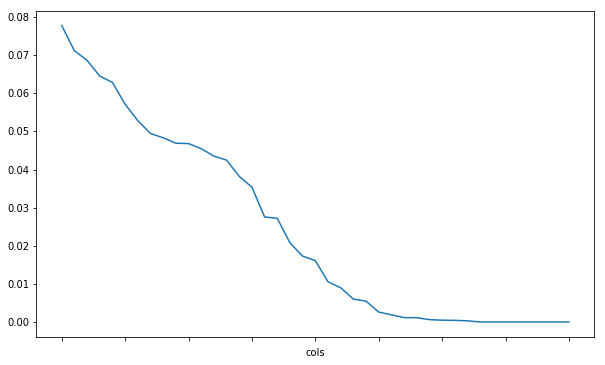

In [76]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [77]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

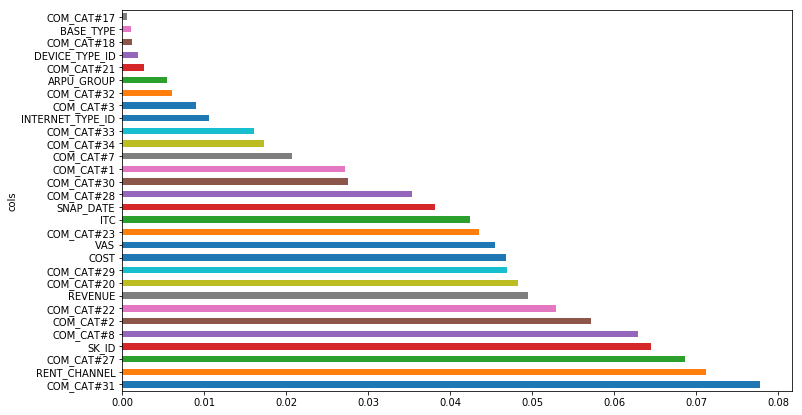

In [78]:
plot_fi(fi[:30]);

In [79]:
fi.describe()

,imp
count,41.000000
mean,0.024390
std,0.025509
min,0.000000
25%,0.000469
50%,0.016080
75%,0.046808
max,0.077805


In [80]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

25

In [81]:
X_train, X_valid = X_train[to_keep], X_valid[to_keep]

In [111]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=40, min_samples_leaf=10, max_features=.5, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 820 ms, sys: 7.97 ms, total: 828 ms
Wall time: 245 ms
[0.9830854309687262, 0.5458012170385395, 0.8452611218568665, 0.8365384615384616, 0.8449387491940683]


In [112]:
train_cats(month_all)

In [113]:
apply_cats(month_test, month_all)

In [114]:
df, y, nas = proc_df(month_all, 'CSI')
test, _, _ = proc_df(month_test, na_dict=nas)

In [115]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=40, min_samples_leaf=10, max_features=.5)
%time m.fit(df[to_keep], y)

CPU times: user 943 ms, sys: 0 ns, total: 943 ms
Wall time: 226 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [116]:
pred_y = m.predict_proba(test[to_keep])[:,1]

In [117]:
subm = pd.DataFrame(pred_y)

In [118]:
subm.to_csv('submits/rf_fi_on_rand_sample.csv', index=False, header=False)